In [36]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Correlated compression experiments

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-research/google-research/blob/master/correlated_compression/correlated_compression_experiments.ipynb)

This notebook contains the experiments run for the paper ["Correlated quantization for distributed mean estimation and optimization"](https://arxiv.org/abs/2203.04925).

In [37]:
# Uncomment this to install fedjax at HEAD.
# !pip install --upgrade -q git+https://github.com/google/fedjax.git

In [38]:
import functools
import itertools
import math
import time

from typing import Any, Callable, Iterable, Mapping, Optional, Sequence, Tuple

import fedjax
import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tensorflow as tf
import tensorflow_datasets as tfds

fedjax.training.set_tf_cpu_only()

## Correlated stochastic quantizer

In [39]:
@fedjax.dataclass
class CorrelatedCompressionState:
  """State of correlated compression aggregator passed between rounds.

  Attributes:
    num_bits: Number of bits transmitted per client.
    rng: PRNGKey used for compression.
    thresholds: Threshold for each array in the pytree.
  """
  num_bits: float
  rng: fedjax.PRNGKey
  thresholds: fedjax.Params


def correlated_stochastic_quantize(v, num_levels, num_clients, rng, shared_rng,
                                   threshold, index, c1):
  """Applies correlated stochastic quantization on input vector v.

  Correlated quantization for distributed mean estimation and optimization
    Ananda Theertha Suresh, Ziteng Sun, Jae Hun Ro, Felix Yu

  Args:
    v: Vector to be quantized.
    num_levels: Number of levels of quantization.
    num_clients: Number of clients.
    rng: PRNGKey.
    shared_rng: PRNGKey that is shared across clients per round.
    threshold: Clipping threshold.
    index: Index of the client.
    c1: Initial value c1.

  Returns:
    Quantized vector and the threshold of v.
  """
  # Rescale the vector to be between zero to one.
  output_min = jnp.amin(v)
  output_max = jnp.amax(v)
  v_min = threshold[0]
  v_max = threshold[1]
  v = jnp.nan_to_num((v - v_min) / (v_max - v_min))
  # Sets v to 0 if v < v_min or 1 if v > v_max.
  v = jnp.maximum(0., jnp.minimum(v, 1.))
  # Since it is expensive to generate a different shared permutation for each
  # coordinate in v for each client, we can work around this by utilizing the
  # client permutation index.
  # Using the shared_rng will make the coordinate samples the same across
  # clients so adding the index will make standard_perm different per client.
  # However, the range of values will be [0, 2n - 2] so we modulo by n to set
  # it back to be a permutation of [0, n - 1].
  standard_perm = jnp.mod(
      jax.random.randint(
          key=shared_rng, shape=v.shape, minval=0, maxval=num_clients) + index,
      num_clients)
  # Add random per coordinate per vector per client value to perm.
  rand = standard_perm + jax.random.uniform(key=rng, shape=v.shape)
  # Scale back to [0, 1].
  rand = rand / num_clients
  if num_levels == 2:
    quantized = jnp.where(rand > v, 0., 1.)
  else:
    # For > 2 levels, we want to adjust the thresholds so that close values are
    # mapped to the same quantization.
    # beta is the interval width.
    # c1 is smallest quant value and ck is largest.
    beta = (num_levels + 1) / (num_levels * (num_levels - 1))
    # c1 is the smallest quantization value (roughly -1/k).
    # ck is the largest quantization value.
    ck = c1 + (num_levels - 1) * beta
    # Scaling v to the new interval [c1, ck].
    v = (v - c1) / (ck - c1)
    # v_ceil and v_floor are the boundaries directly above and below v.
    v_ceil = jnp.ceil(v * (num_levels - 1)) / (num_levels - 1)
    v_floor = jnp.floor(v * (num_levels - 1)) / (num_levels - 1)
    # Scaling threshold between v_ceil and v_floor to determine probability of
    # rounding up to v_ceil.
    threshold = jnp.nan_to_num((v - v_floor) / (v_ceil - v_floor))
    quantized = jnp.where(rand > threshold, v_floor, v_ceil)
    # Rescale back to [v_min, v_max].
    quantized = c1 + (ck - c1) * quantized
  # Rescale the values and return it.
  quantized_v = v_min + quantized * (v_max - v_min)
  new_threshold = jnp.array([output_min, output_max])
  return quantized_v, new_threshold


@functools.partial(jax.jit, static_argnums=(1))
def correlated_stochastic_quantize_pytree(params, num_levels, num_clients,
                                          client_rng, shared_rng, thresholds,
                                          index, c1s):
  """Applies correlated quantization for all leaves of the params pytree.

  Args:
    params: Pytree of parameters to be quantized.
    num_levels: Number of levels of quantization.
    num_clients: Number of clients.
    client_rng: PRNGKey of client.
    shared_rng: PRNGKey that is shared across clients in a round.
    thresholds: A pytree of absolute mins and maxes for each array in params.
    index: Index of the user.
    c1s: Initial value c1s.

  Returns:
    Quantized params pytree and the pytree of thresholds.
  """
  p_leaves, p_tree_def = jax.tree_util.tree_flatten(params)
  thresh_leaves, thresh_tree_def = jax.tree_util.tree_flatten(thresholds)
  p_rngs = jax.random.split(client_rng, len(p_leaves))
  # Split the shared key so a different key is used for each parameter but is
  # still identical across clients.
  shared_rngs = jax.random.split(shared_rng, len(p_leaves))
  quant_p_leaves = []
  new_thresh_leaves = []
  for p_leaf, p_rng, s_rng, thresh, c1 in zip(p_leaves, p_rngs, shared_rngs,
                                              thresh_leaves, c1s):
    quant_p_leaf, new_thresh = correlated_stochastic_quantize(
        p_leaf, num_levels, num_clients, p_rng, s_rng, thresh, index, c1)
    quant_p_leaves.append(quant_p_leaf)
    new_thresh_leaves.append(new_thresh)
  quant_params = jax.tree_util.tree_unflatten(p_tree_def, quant_p_leaves)
  new_thresholds = jax.tree_util.tree_unflatten(thresh_tree_def,
                                                new_thresh_leaves)
  return quant_params, new_thresholds


def correlated_stochastic_quantizer(
    num_levels: int,
    rng: fedjax.PRNGKey,
    num_clients: int,
    thresholds: fedjax.Params,
    update_thresholds: bool,
    rotate: bool = False) -> fedjax.aggregators.Aggregator:
  """Returns aggregator for computing (weighted) mean of inputs after correlated quantization.

  Correlated quantization for distributed mean estimation and optimization
    Ananda Theertha Suresh, Ziteng Sun, Jae Hun Ro, Felix Yu

  Args:
    num_levels: Number of levels of quantization.
    rng: PRNGKey used for compression.
    num_clients: Number of clients.
    thresholds: A pytree of absolute mins and maxes for each array.
    update_thresholds: Whether thresholds should be updated.
    rotate: Whether to apply efficient Walsh-Hadamard rotation.

  Returns:
    Correlated compression aggregator.
  """

  def init():
    return CorrelatedCompressionState(
        num_bits=0.0, rng=rng, thresholds=thresholds)

  def apply(
      clients_params_and_weights: Iterable[Tuple[fedjax.ClientId, fedjax.Params,
                                                 float]],
      aggregator_state: CorrelatedCompressionState
  ) -> Tuple[fedjax.Params, CorrelatedCompressionState]:

    rng, c1s_rng, perms_rng, hk_rng, rotate_rng, shared_rng = jax.random.split(
        aggregator_state.rng, 6)
    # c1s are uniformly distributed in the interval [-1/k, 0).
    c1s = -jax.random.uniform(
        key=c1s_rng,
        shape=[fedjax.aggregators.compression.num_leaves(thresholds)
              ]) / num_levels
    # π random permutation of {0, 1, 2, ..., n - 1}.
    pi = jax.random.shuffle(perms_rng, jnp.arange(num_clients))
    # Unpack into a single tuple containing (cid, params, weight, rng, index).
    clients_params_weight_rng_pis = map(lambda cpw, r, p: (*cpw, r, p),
                                        clients_params_and_weights,
                                        hk.PRNGSequence(hk_rng), pi)
    # Optionally update thresholds by recording max and min across clients while
    # streaming for quantization.
    new_thresholds_leaves = []
    # Convenience array to switch sign of left threshold so we can do a single
    # element-wise maximum over both.
    lsign = jnp.array([-1.0, 1.0])

    def quantize_params(cid, params, weight, rng, index):
      del cid
      nonlocal new_thresholds_leaves
      if rotate:
        rotated_params, params_shapes = fedjax.aggregators.walsh_hadamard.structured_rotation_pytree(
            params, rotate_rng)
        q_rotated_params, thresholds = correlated_stochastic_quantize_pytree(
            rotated_params, num_levels, num_clients, rng, shared_rng,
            aggregator_state.thresholds, index, c1s)
        q_params = fedjax.aggregators.walsh_hadamard.inverse_structured_rotation_pytree(
            q_rotated_params, rotate_rng, params_shapes)
      else:
        q_params, thresholds = correlated_stochastic_quantize_pytree(
            params, num_levels, num_clients, rng, shared_rng,
            aggregator_state.thresholds, index, c1s)
      if update_thresholds:
        # Record current min left and max right thresholds for each leaf.
        thresholds_leaves = jax.tree_util.tree_leaves(thresholds)
        if not new_thresholds_leaves:
          new_thresholds_leaves = thresholds_leaves
        else:
          for i in range(len(thresholds_leaves)):
            new_thresholds_leaves[i] = jnp.maximum(
                thresholds_leaves[i] * lsign,
                new_thresholds_leaves[i] * lsign) * lsign
      return q_params, weight

    # Quantize parameters and (possibly) generate new thresholds in stream.
    q_params_and_weights = itertools.starmap(quantize_params,
                                             clients_params_weight_rng_pis)
    aggregated_params = fedjax.tree_util.tree_mean(q_params_and_weights)
    total_num_params = fedjax.tree_util.tree_size(aggregated_params)
    total_num_floats = 2 * fedjax.aggregators.compression.num_leaves(
        aggregated_params)
    # 32 bits for every float used and one bit for every parameter.
    new_bits = total_num_params + 32 * total_num_floats
    # Possibly update thresholds.
    if update_thresholds:
      thresholds_tree_def = jax.tree_util.tree_structure(
          aggregator_state.thresholds)
      new_thresholds = jax.tree_util.tree_unflatten(thresholds_tree_def,
                                                    new_thresholds_leaves)
    else:
      new_thresholds = aggregator_state.thresholds
    new_aggregator_state = CorrelatedCompressionState(
        num_bits=aggregator_state.num_bits + new_bits,
        rng=rng,
        thresholds=new_thresholds)
    return aggregated_params, new_aggregator_state

  return fedjax.aggregators.Aggregator(init, apply)

## Experiment utils

In [40]:
def get_quantizers(rng, num_levels, num_clients, thresholds, update_thresholds):
  return {
      'None':
          fedjax.aggregators.mean_aggregator(),
      'Independent':
          fedjax.aggregators.compression.uniform_stochastic_quantizer(
              num_levels, rng),
      'Independent+Rotation':
          fedjax.aggregators.compression.rotated_uniform_stochastic_quantizer(
              num_levels, rng),
      'TernGrad':
          fedjax.aggregators.compression.terngrad_quantizer(rng),
      'DRIVE':
          fedjax.aggregators.compression.structured_drive_quantizer(rng),
      'Correlated':
          correlated_stochastic_quantizer(num_levels, rng, num_clients,
                                          thresholds, update_thresholds),
      'Correlated+Rotation':
          correlated_stochastic_quantizer(
              num_levels,
              rng,
              num_clients,
              thresholds,
              update_thresholds,
              rotate=True),
  }

In [41]:
def depends_on_num_levels(quantizer_name):
  return quantizer_name not in ('None', 'DRIVE', 'TernGrad')


def only_independent_and_correlated(quantizers):
  return {
      k: v for k, v in quantizers.items() if k in ('Independent', 'Correlated')
  }


def only_independent_and_correlated_and_rotation(quantizers):
  return {
      k: v
      for k, v in quantizers.items()
      if k in ('Independent', 'Correlated', 'Correlated+Rotation',
               'Independent+Rotation')
  }

## Toy Examples

### Correlated vs independent stochastic quantization

We first compare correlated and independent stochastic
quantizations on a simple mean estimation task.

Let x1,x2,...,xn be n i.i.d ̇ samples over R16, where each
coordinate is sampled independently according to μ + U,
where μ is a uniform random variable between [0,1] and is
fixed for all clients and U is a independent random variable
for each client in the range −[4σmd,4σmd]. We refer to this
distribution as punif. Note that punif has mean deviation of
σmd.

In [42]:
@functools.partial(jax.jit, static_argnums=(3, 4))
def _sample(rng, mean, sigmamd, dimension, dist):
  rng, use_rng = jax.random.split(rng)
  if dist == 'punif':
    x = mean + 4 * sigmamd * jax.random.uniform(use_rng, shape=[dimension])
    return (x, rng)


def run_dist_mean(aggregator,
                  mean,
                  sigmamd,
                  num_clients,
                  rng,
                  dimension=16,
                  num_iters=10,
                  dist='punif'):
  start = time.time()
  distances = []
  state = aggregator.init()
  true_mean_aggregator = fedjax.aggregators.mean_aggregator()
  true_mean_empty_state = true_mean_aggregator.init()
  for iter_num in range(num_iters + 1):
    client_id_x_weights = []
    for i in range(num_clients):
      x, rng = _sample(rng, mean, sigmamd, dimension, dist)
      client_id_x_weights.append((i, x, 1))
    true_mean, _ = true_mean_aggregator.apply(client_id_x_weights,
                                              true_mean_empty_state)
    aggregated_mean, state = aggregator.apply(client_id_x_weights, state)
    if iter_num > 0:
      # We skip the first iteration, so thresholds can be set correctly for
      # all the algorithms.
      distance = jnp.linalg.norm(aggregated_mean - true_mean)
      distances.append(distance)
  print(f'average iteration duration = {(time.time() - start) / num_iters} sec')
  return jnp.array(distances)

We first fix the number of clients to be 100, k = 2,
and vary σmd

In [43]:
def run_vary_sigmamd(seed, sigmamd_range):
  rng, mean_rng, quant_rng = jax.random.split(jax.random.PRNGKey(seed), 3)
  dimension = 1024
  mean = jax.random.uniform(key=mean_rng, shape=[dimension])
  num_clients = 100

  vary_sigmamd_metrics = {}
  for sigmamd in sigmamd_range:
    quantizers = get_quantizers(
        quant_rng,
        num_levels=2,
        num_clients=num_clients,
        thresholds=jnp.array([0, 1. + 4 * sigmamd]),
        update_thresholds=False)
    # Just independent and correlated.
    quantizers = only_independent_and_correlated(quantizers)
    for quantizer_name, quantizer_agg in quantizers.items():
      if quantizer_name not in vary_sigmamd_metrics:
        vary_sigmamd_metrics[quantizer_name] = {'sigmamd': [], 'distances': []}
      vary_sigmamd_metrics[quantizer_name]['sigmamd'].append(sigmamd)
      distances = run_dist_mean(
          quantizer_agg,
          mean,
          sigmamd,
          num_clients,
          rng,
          dimension,
          num_iters=10)
      vary_sigmamd_metrics[quantizer_name]['distances'].append(distances)
      print(f'Finished {quantizer_name} sigmamd={sigmamd}')
  return vary_sigmamd_metrics


vary_sigmamd_metrics = run_vary_sigmamd(
    seed=47, sigmamd_range=[0.01, 0.02, 0.04, 0.08, 0.16])

average iteration duration = 0.10913488864898682 sec
Finished Independent sigmamd=0.01
average iteration duration = 0.16218764781951905 sec
Finished Correlated sigmamd=0.01
average iteration duration = 0.0569476842880249 sec
Finished Independent sigmamd=0.02
average iteration duration = 0.06662611961364746 sec
Finished Correlated sigmamd=0.02
average iteration duration = 0.05702245235443115 sec
Finished Independent sigmamd=0.04
average iteration duration = 0.06564192771911621 sec
Finished Correlated sigmamd=0.04
average iteration duration = 0.05737545490264893 sec
Finished Independent sigmamd=0.08
average iteration duration = 0.06603660583496093 sec
Finished Correlated sigmamd=0.08
average iteration duration = 0.05976698398590088 sec
Finished Independent sigmamd=0.16
average iteration duration = 0.06861958503723145 sec
Finished Correlated sigmamd=0.16


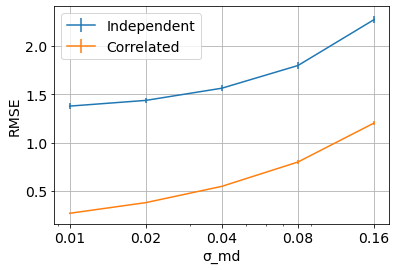

In [44]:
font = {'family': 'normal', 'weight': 'normal', 'size': 14}
matplotlib.rc('font', **font)

for quant_name, metrics in vary_sigmamd_metrics.items():
  distances = jnp.array(metrics['distances'])
  plt.errorbar(
      metrics['sigmamd'],
      jnp.mean(distances, axis=1),
      jnp.std(distances, axis=1),
      label=quant_name)
plt.legend()
plt.xlabel('σ_md')
plt.ylabel('RMSE')
plt.xscale('log')
plt.xticks(
    ticks=metrics['sigmamd'], labels=[f'{s}' for s in metrics['sigmamd']])
plt.grid()

We then fix σmd = 0.1, k = 2 and vary the number of clients n

In [45]:
def run_vary_num_clients(seed, num_clients_range):
  rng, mean_rng, quant_rng = jax.random.split(jax.random.PRNGKey(seed), 3)
  dimension = 1024
  mean = jax.random.uniform(key=mean_rng, shape=[dimension])
  sigmamd = 0.01

  vary_num_clients_metrics = {}
  for num_clients in num_clients_range:
    quantizers = get_quantizers(
        quant_rng,
        num_levels=2,
        num_clients=num_clients,
        thresholds=jnp.array([0., 1. + 4 * sigmamd]),
        update_thresholds=False)
    # Just independent and correlated.
    quantizers = only_independent_and_correlated(quantizers)
    for quantizer_name, quantizer_agg in quantizers.items():
      if quantizer_name not in vary_num_clients_metrics:
        vary_num_clients_metrics[quantizer_name] = {
            'num_clients': [],
            'distances': [],
        }
      vary_num_clients_metrics[quantizer_name]['num_clients'].append(
          num_clients)
      distances = run_dist_mean(
          quantizer_agg,
          mean,
          sigmamd,
          num_clients,
          rng,
          dimension,
          num_iters=10)
      vary_num_clients_metrics[quantizer_name]['distances'].append(distances)
      print(f'Finished {quantizer_name} num_clients={num_clients}')
  return vary_num_clients_metrics


vary_num_clients_metrics = run_vary_num_clients(
    seed=47, num_clients_range=[10, 20, 40, 80, 160])

average iteration duration = 0.006571912765502929 sec
Finished Independent num_clients=10
average iteration duration = 0.007915973663330078 sec
Finished Correlated num_clients=10
average iteration duration = 0.012097597122192383 sec
Finished Independent num_clients=20
average iteration duration = 0.014271211624145509 sec
Finished Correlated num_clients=20
average iteration duration = 0.02355680465698242 sec
Finished Independent num_clients=40
average iteration duration = 0.026767754554748537 sec
Finished Correlated num_clients=40
average iteration duration = 0.045855236053466794 sec
Finished Independent num_clients=80
average iteration duration = 0.05214083194732666 sec
Finished Correlated num_clients=80
average iteration duration = 0.09013292789459229 sec
Finished Independent num_clients=160
average iteration duration = 0.11289191246032715 sec
Finished Correlated num_clients=160


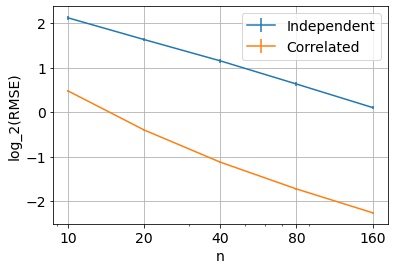

In [46]:
for quant_name, metrics in vary_num_clients_metrics.items():
  distances = jnp.array(metrics['distances'])
  distances = jnp.log2(distances)
  plt.errorbar(
      metrics['num_clients'],
      jnp.mean(distances, axis=1),
      jnp.std(distances, axis=1),
      label=quant_name)
plt.legend()
plt.xlabel('n')
plt.ylabel('log_2(RMSE)')
plt.xscale('log')
plt.xticks(
    ticks=metrics['num_clients'],
    labels=[f'{s}' for s in metrics['num_clients']])
plt.grid()

Finally, we fix σmd = 0.1, n = 100 and vary k (num_levels for quantization)

In [47]:
def run_vary_num_levels(seed, num_levels_range):
  rng, mean_rng, quant_rng = jax.random.split(jax.random.PRNGKey(seed), 3)
  dimension = 1024
  mean = jax.random.uniform(key=mean_rng, shape=[dimension])
  sigmamd = 0.01
  num_clients = 100

  vary_num_levels_metrics = {}
  for num_levels in num_levels_range:
    quantizers = get_quantizers(
        quant_rng,
        num_levels=num_levels,
        num_clients=num_clients,
        thresholds=jnp.array([0., 1. + 4 * sigmamd]),
        update_thresholds=False)
    # Just independent and correlated.
    quantizers = only_independent_and_correlated(quantizers)
    for quantizer_name, quantizer_agg in quantizers.items():
      if quantizer_name not in vary_num_levels_metrics:
        vary_num_levels_metrics[quantizer_name] = {
            'num_levels': [],
            'distances': [],
        }
      vary_num_levels_metrics[quantizer_name]['num_levels'].append(num_levels)
      distances = run_dist_mean(
          quantizer_agg,
          mean,
          sigmamd,
          num_clients,
          rng,
          dimension,
          num_iters=10)
      vary_num_levels_metrics[quantizer_name]['distances'].append(distances)
      print(f'Finished {quantizer_name} num_levels={num_levels}')
  return vary_num_levels_metrics


vary_num_levels_metrics = run_vary_num_levels(
    seed=49, num_levels_range=[2, 4, 8, 16])

average iteration duration = 0.0743243932723999 sec
Finished Independent num_levels=2
average iteration duration = 0.08959975242614746 sec
Finished Correlated num_levels=2
average iteration duration = 0.0805504322052002 sec
Finished Independent num_levels=4
average iteration duration = 0.18020777702331542 sec
Finished Correlated num_levels=4
average iteration duration = 0.07850604057312012 sec
Finished Independent num_levels=8
average iteration duration = 0.1702652931213379 sec
Finished Correlated num_levels=8
average iteration duration = 0.07107608318328858 sec
Finished Independent num_levels=16
average iteration duration = 0.16953704357147217 sec
Finished Correlated num_levels=16


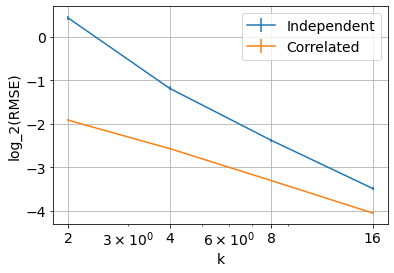

In [48]:
for quant_name, metrics in vary_num_levels_metrics.items():
  distances = jnp.array(metrics['distances'])
  distances = jnp.log2(distances)
  plt.errorbar(
      metrics['num_levels'],
      jnp.mean(distances, axis=1),
      jnp.std(distances, axis=1),
      label=quant_name)
plt.legend()
plt.xlabel('k')
plt.ylabel('log_2(RMSE)')
plt.xscale('log')
plt.xticks(
    ticks=metrics['num_levels'], labels=[f'{s}' for s in metrics['num_levels']])
plt.grid()

### Effect of random rotation

In [49]:
def run_vary_num_clients(seed, num_clients_range):
  rng, mean_rng, quant_rng = jax.random.split(jax.random.PRNGKey(seed), 3)
  dimension = 1024
  mean = jnp.zeros(shape=[dimension])
  mean = mean.at[0].set(1.)
  mean = mean.at[1].set(-1.)
  sigmamd = 0.01

  vary_num_clients_metrics = {}
  for num_clients in num_clients_range:
    quantizers = get_quantizers(
        quant_rng,
        num_levels=2,
        num_clients=num_clients,
        thresholds=jnp.array([0., 1. + 4 * sigmamd]),
        update_thresholds=True)
    # Just independent and correlated.
    quantizers = only_independent_and_correlated_and_rotation(quantizers)
    for quantizer_name, quantizer_agg in quantizers.items():
      if quantizer_name not in vary_num_clients_metrics:
        vary_num_clients_metrics[quantizer_name] = {
            'num_clients': [],
            'distances': [],
        }
      vary_num_clients_metrics[quantizer_name]['num_clients'].append(
          num_clients)
      distances = run_dist_mean(
          quantizer_agg,
          mean,
          sigmamd,
          num_clients,
          rng,
          dimension,
          num_iters=10)
      vary_num_clients_metrics[quantizer_name]['distances'].append(distances)
      print(f'Finished {quantizer_name} num_clients={num_clients}')
  return vary_num_clients_metrics


vary_num_clients_metrics_rot = run_vary_num_clients(
    seed=47, num_clients_range=[10, 20, 40, 80, 160])

average iteration duration = 0.007363462448120117 sec
Finished Independent num_clients=10
average iteration duration = 0.020679330825805663 sec
Finished Independent+Rotation num_clients=10
average iteration duration = 0.011248159408569335 sec
Finished Correlated num_clients=10
average iteration duration = 0.025571107864379883 sec
Finished Correlated+Rotation num_clients=10
average iteration duration = 0.014239072799682617 sec
Finished Independent num_clients=20
average iteration duration = 0.042512011528015134 sec
Finished Independent+Rotation num_clients=20
average iteration duration = 0.02191011905670166 sec
Finished Correlated num_clients=20
average iteration duration = 0.04720735549926758 sec
Finished Correlated+Rotation num_clients=20
average iteration duration = 0.022398042678833007 sec
Finished Independent num_clients=40
average iteration duration = 0.06663603782653808 sec
Finished Independent+Rotation num_clients=40
average iteration duration = 0.03333437442779541 sec
Finished 

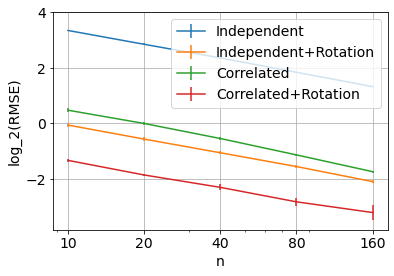

In [50]:
for quant_name, metrics in vary_num_clients_metrics_rot.items():
  distances = jnp.array(metrics['distances'])
  distances = jnp.log2(distances)
  plt.errorbar(
      metrics['num_clients'],
      jnp.mean(distances, axis=1),
      jnp.std(distances, axis=1),
      label=quant_name)
plt.legend()
plt.xlabel('n')
plt.ylabel('log_2(RMSE)')
plt.ylim(top=4.0)
plt.xscale('log')
plt.xticks(
    ticks=metrics['num_clients'],
    labels=[f'{s}' for s in metrics['num_clients']])
plt.grid()

### Distributed mean estimation

In [51]:
def run_vary_num_clients(seed, num_clients_range):
  rng, mean_rng, quant_rng = jax.random.split(jax.random.PRNGKey(seed), 3)
  dimension = 1024
  mean = jax.random.uniform(key=mean_rng, shape=[dimension])
  mean = jnp.where(mean > 0.99, 1. * jnp.sign(mean - 0.995), 0.)
  sigmamd = 0.01

  vary_num_clients_metrics = {}
  for num_clients in num_clients_range:
    quantizers = get_quantizers(
        quant_rng,
        num_levels=2,
        num_clients=num_clients,
        thresholds=jnp.array([0., 1. + 4 * sigmamd]),
        update_thresholds=True)
    for quantizer_name, quantizer_agg in quantizers.items():
      if quantizer_name not in vary_num_clients_metrics:
        vary_num_clients_metrics[quantizer_name] = {
            'num_clients': [],
            'distances': [],
        }
      vary_num_clients_metrics[quantizer_name]['num_clients'].append(
          num_clients)
      distances = run_dist_mean(
          quantizer_agg,
          mean,
          sigmamd,
          num_clients,
          rng,
          dimension,
          dist='punif',
          num_iters=10)
      vary_num_clients_metrics[quantizer_name]['distances'].append(distances)
      print(f'Finished {quantizer_name} num_clients={num_clients}')
  return vary_num_clients_metrics

vary_num_clients_metrics = run_vary_num_clients(
    seed=47, num_clients_range=[10])

average iteration duration = 0.0034392833709716796 sec
Finished None num_clients=10
average iteration duration = 0.006197118759155273 sec
Finished Independent num_clients=10
average iteration duration = 0.01759061813354492 sec
Finished Independent+Rotation num_clients=10
average iteration duration = 0.006282424926757813 sec
Finished TernGrad num_clients=10
average iteration duration = 0.017534089088439942 sec
Finished DRIVE num_clients=10
average iteration duration = 0.009972429275512696 sec
Finished Correlated num_clients=10
average iteration duration = 0.022092914581298827 sec
Finished Correlated+Rotation num_clients=10


In [52]:
for quant_name, metrics in vary_num_clients_metrics.items():
  distances = jnp.array(metrics['distances'])
  print(quant_name,
        jnp.mean(distances, axis=1)[0],
        jnp.std(distances, axis=1)[0])

None 0.0 0.0
Independent 10.279256 0.24624498
Independent+Rotation 3.287459 0.19471912
TernGrad 2.6432343 0.0067978394
DRIVE 0.84225017 0.014251265
Correlated 1.401985 0.05315395
Correlated+Rotation 1.0122799 0.055120073


## MNIST (d=784)

MNIST dataset with pixels (28, 28) flattened (784).

In [53]:
DIMENSION = 784

def flatten_pad_normalize(d):
  return tf.pad(tf.reshape(d['image'], [-1]), [[0, DIMENSION - 784]]) / 255


mnist_ds = tfds.load(name='mnist', split='train')
# Read into memory.
mnist_x = jnp.array(
    list(mnist_ds.map(flatten_pad_normalize).as_numpy_iterator()))

In [54]:
def partition_data(x, k, rng):
  partitions = []
  num_examples = x.shape[0]
  perm = jax.random.permutation(rng, num_examples)
  num_per_client = math.floor(num_examples / k)
  for i in range(k):
    low = i * num_per_client
    # In case it can't be split evenly.
    if (i + 1) == k:
      high = num_examples
    else:
      high = (i + 1) * num_per_client
    partitions.append(x[perm[low:high], :])
  return partitions

### Distributed mean estimation

In [55]:
def run_dist_mean2(x,
                   aggregator,
                   rng,
                   num_clients=100,
                   num_iters=10,
                   verbose=True):
  start = time.time()
  experiment_metrics = {
      'distances': [],
  }
  # Ground truth mean.
  true_mean = jnp.mean(x, axis=0)
  # Init aggregator state.
  aggregator_state = aggregator.init()
  for it in range(num_iters + 1):
    rng, client_rng = jax.random.split(rng)
    # Split and distribute clients.
    clients = partition_data(x, num_clients, client_rng)
    local_means = []
    local_weights = []
    for local_x in clients:
      local_means.append(jnp.mean(local_x, axis=0))
      local_weights.append(local_x.shape[0])
    aggregated_mean, aggregator_state = aggregator.apply(
        [(j, local_means[j], local_weights[j]) for j in range(num_clients)],
        aggregator_state)
    # Distance between current estimated mean and groundtruth mean.
    distance = jnp.linalg.norm(true_mean - aggregated_mean)
    if it > 0:
      experiment_metrics['distances'].append(distance)
  end = time.time()
  print(f'Average iteration duration = {(end - start)/num_iters} sec')
  return {k: jnp.array(v) for k, v in experiment_metrics.items()}


def run_dist_mean2_experiment(seed, num_levels_range):
  experiment_metrics = {}
  for num_levels in num_levels_range:
    key = f'num_levels={num_levels} seed={seed}'
    experiment_metrics[key] = {}
    mean_metrics = experiment_metrics[key]
    num_clients = 100
    rng = jax.random.PRNGKey(seed)
    rng, quant_rng = jax.random.split(rng)
    quantizers = get_quantizers(
        rng=quant_rng,
        num_levels=num_levels,
        num_clients=num_clients,
        thresholds=jnp.array([0., 1.]),
        update_thresholds=True)
    for quantizer_name, quantizer in quantizers.items():
      mean_metrics[quantizer_name] = run_dist_mean2(
          mnist_x,
          quantizer,
          rng,
          num_clients=num_clients,
          num_iters=10,
          verbose=False)
      print(f'Finished {quantizer_name} {key}')
  return experiment_metrics


experiment_mean_metrics = run_dist_mean2_experiment(
    seed=47, num_levels_range=[2])

Average iteration duration = 0.31287455558776855 sec
Finished None num_levels=2 seed=47
Average iteration duration = 0.3519250154495239 sec
Finished Independent num_levels=2 seed=47
Average iteration duration = 0.49955313205718993 sec
Finished Independent+Rotation num_levels=2 seed=47
Average iteration duration = 0.3531170845031738 sec
Finished TernGrad num_levels=2 seed=47
Average iteration duration = 0.46698195934295655 sec
Finished DRIVE num_levels=2 seed=47
Average iteration duration = 0.4603892803192139 sec
Finished Correlated num_levels=2 seed=47
Average iteration duration = 0.4926802158355713 sec
Finished Correlated+Rotation num_levels=2 seed=47


In [56]:
for quantizer_name, metrics in experiment_mean_metrics[
    'num_levels=2 seed=47'].items():
  print(quantizer_name, jnp.mean(metrics['distances']),
        jnp.std(metrics['distances']))

None 1.1163191e-06 3.5329478e-08
Independent 0.46585464 0.013661128
Independent+Rotation 1.6608591 0.12572193
TernGrad 0.6213985 0.005817535
DRIVE 0.40258288 0.014060988
Correlated 0.14114387 0.0041163075
Correlated+Rotation 0.23769055 0.011894402


### Distributed Lloyd's algorithm (k-means)

MNIST (d=784)

Each client has access to a subset of data points.
In each iteration, the server broadcasts the cluster centers to all the clients.
Each client updates the centers based on its local data, and sends the centers
back to the server.
The server then updates the centers by computing the weighted average of the
centers sent from all clients.

In the quantized setting, the client compresses the new centers before
sending to the server. This saves the uplink communication cost.

Number of centers and number of clients is 10.

In [57]:
# [num_examples, d]
X = jnp.array([[2, 3, 4, 2, 0, 0], [2, 3, 6, 2, 0, 0], [1, 3, 4, 2, 0, 0]])
# [num_centers, d]
centers = jnp.array([[1, -2, 1, 3, 0, 0], [6, -2, -1, 3, 0, 0]])

# Manual calc to check for correctness.
# [[6.0, 7.2111025, 5.9160795],
#  [8.185352, 9.5393915, 8.717797]]
# for c in centers:
#   for x in X:
#     print(c, x)
#     print(jnp.linalg.norm(x - c))
# matches behavior when using Matlab's pdist2 with euclidean
# https://www.mathworks.com/help/stats/pdist2.html

# Due to slow initial compilations for each shape (10 clients), try to run this
# cell only once so we can use the cached compilations.
# jit for speed
distance = jax.jit(
    # Outer vmap vectorizes over multiple centers and broadcasts examples.
    jax.vmap(
        # Inner vmap vectorizes over num examples and broadcasts center.
        jax.vmap(
            lambda x, center: jnp.linalg.norm(x - center), in_axes=(0, None)),
        in_axes=(None, 0)))
print(distance(X, centers))

[[6.        7.2111025 5.9160795]
 [8.185353  9.539392  8.717797 ]]


In [58]:
def choose_random_centers(x, k, rng):
  num_examples = x.shape[0]
  perm = jax.random.permutation(rng, num_examples)
  return x[perm[:k], :]


def single_kmeans_iter(x, centers):
  # x is [num_examples, d]
  # centers is [num_centers, d]
  # dist is [num_centers, num_examples]
  dist = distance(x, centers)
  # obj_dist is [num_examples]
  obj_dist = jnp.min(dist, axis=0)
  # obj_label is [num_examples]
  obj_label = jnp.argmin(dist, axis=0)
  obj = jnp.sum(obj_dist)
  new_centers = []
  centers_weights = []
  for i in range(centers.shape[0]):
    mask = obj_label == i
    num = jnp.sum(mask)
    if num > 0:
      # Recompute center.
      new_center = jnp.sum(jnp.expand_dims(mask, 1) * x, axis=0) / num
      new_center = jnp.nan_to_num(new_center)
      new_centers.append(new_center)
    else:
      # Keep original center.
      # Dumb way to make sure there's no funny business going on with references
      new_centers.append(jnp.ones_like(centers[i]) * centers[i])
    centers_weights.append(num)
  new_centers = jnp.array(new_centers)
  centers_weights = jnp.array(centers_weights)
  return (new_centers, centers_weights, obj)


def choose_kmeanspp_centers(x, k, rng):
  rng, use_rng = jax.random.split(rng)
  num_examples = x.shape[0]
  idx = jax.random.randint(use_rng, shape=(), minval=0, maxval=num_examples)
  centers = [x[idx]]
  for i in range(k - 1):
    rng, use_rng = jax.random.split(rng)
    dist = distance(x, jnp.array(centers))
    obj = jnp.min(jnp.square(dist), axis=0)
    probs = obj / jnp.sum(obj)
    idx = jax.random.choice(use_rng, jnp.arange(num_examples), p=probs)
    centers.append(x[idx])
  return jnp.array(centers)

In [59]:
def run_dist_kmeans(x,
                    aggregator_name,
                    aggregator,
                    rng,
                    num_clients=10,
                    num_centers=10,
                    num_rounds=50,
                    num_iters=10,
                    verbose=True):
  start = time.time()
  # Run multiple multiple trials.
  metrics = {
      'comm_rounds': [],
      'round_dist': [],
      'round_obj': [],
      'centers': [],
  }
  # Aggregator state per center.
  aggregator_states = [aggregator.init() for _ in range(num_centers)]
  for it in range(num_iters + 1):
    rng, client_rng, center_rng = jax.random.split(rng, 3)
    # Split dataset EVENLY into i.i.d. clients.
    clients = partition_data(x, num_clients, client_rng)
    # # Initialize centers by randomly selecting N points in X.
    # centers = choose_random_centers(x, num_centers, center_rng)
    # Initialize centers via kmeans++ algorithm.
    centers = choose_kmeanspp_centers(x, num_centers, center_rng)
    comm_rounds = []
    round_dist = []
    round_obj = []
    for t in range(num_rounds):
      # [num_clients, num_centers, d]
      client_centers = []
      # [num_clients, num_centers]
      client_weights = []
      # [num_clients]
      client_objectives = []
      for local_x in clients:
        local_centers, local_weights, _ = single_kmeans_iter(local_x, centers)
        client_centers.append(local_centers)
        client_weights.append(local_weights)
      # Aggregate
      new_aggregator_states = [None for _ in range(num_centers)]
      new_centers = [None for _ in range(num_centers)]
      for i in range(num_centers):
        new_centers[i], new_aggregator_states[i] = aggregator.apply(
            [(j, client_centers[j][i], client_weights[j][i])
             for j in range(num_clients)], aggregator_states[i])
      centers = jnp.nan_to_num(jnp.array(new_centers))
      aggregator_states = new_aggregator_states
      dist = distance(mnist_x, centers)
      obj_dist = jnp.min(dist, axis=0)
      round_dist.append(jnp.mean(obj_dist))
      # Objective according to https://en.wikipedia.org/wiki/K-means_clustering
      round_obj.append(jnp.mean(jnp.square(obj_dist)))
      comm_rounds.append(t + 1)
      if t % 10 == 0 and verbose:
        print(f'{t} obj: {round_obj[t]} dist: {round_dist[t]}')
    if it > 0:
      metrics['comm_rounds'].append(comm_rounds)
      metrics['round_dist'].append(round_dist)
      metrics['round_obj'].append(round_obj)
      metrics['centers'].append(centers)
  print(f'Average iteration duration = {(time.time() - start)/num_iters} sec')
  return {k: jnp.array(v) for k, v in metrics.items()}


def run_dist_kmeans_experiment(seed, num_levels_range):
  experiment_metrics = {}
  cache = {}
  for num_levels in num_levels_range:
    key = f'num_levels={num_levels} seed={seed}'
    experiment_metrics[key] = {}
    kmeans_metrics = experiment_metrics[key]
    num_clients = 10
    rng = jax.random.PRNGKey(seed)
    rng, quant_rng = jax.random.split(rng)
    quantizers = get_quantizers(
        rng=quant_rng,
        num_levels=num_levels,
        num_clients=num_clients,
        thresholds=jnp.array([0., 1.]),
        update_thresholds=True)
    for quantizer_name, quantizer in quantizers.items():
      if not depends_on_num_levels(quantizer_name) and quantizer_name in cache:
        # Does not depend on num_levels and already run so we can safely reuse.
        kmeans_metrics[quantizer_name] = cache[quantizer_name]
      else:
        kmeans_metrics[quantizer_name] = run_dist_kmeans(
            mnist_x,
            quantizer_name,
            quantizer,
            rng,
            num_clients=num_clients,
            num_centers=10,
            num_rounds=20,
            num_iters=10,
            verbose=False)
        cache[quantizer_name] = kmeans_metrics[quantizer_name]
      print(f'Finished {quantizer_name} {key}')
  return experiment_metrics


experiment_kmeans_metrics = run_dist_kmeans_experiment(
    seed=47, num_levels_range=[2])

Average iteration duration = 9.565997743606568 sec
Finished None num_levels=2 seed=47
Average iteration duration = 8.914821243286132 sec
Finished Independent num_levels=2 seed=47
Average iteration duration = 13.254502844810485 sec
Finished Independent+Rotation num_levels=2 seed=47
Average iteration duration = 8.810287237167358 sec
Finished TernGrad num_levels=2 seed=47
Average iteration duration = 11.446314692497253 sec
Finished DRIVE num_levels=2 seed=47


Average iteration duration = 9.462021088600158 sec
Finished Correlated num_levels=2 seed=47
Average iteration duration = 12.301705312728881 sec
Finished Correlated+Rotation num_levels=2 seed=47


None 20.0 39.434612 0.118846945
Independent 20.0 42.976254 0.23430422
Independent+Rotation 20.0 68.85003 2.8117113
TernGrad 20.0 42.072174 0.08683029
DRIVE 20.0 41.645218 0.13038877
Correlated 20.0 39.974834 0.12771523
Correlated+Rotation 20.0 42.20631 0.17438135


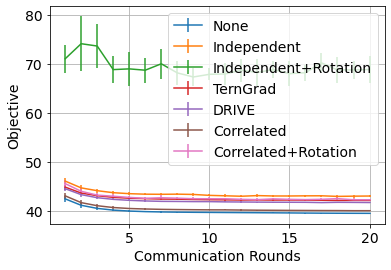

In [60]:
STOP = 20
for quantizer_name, metrics in experiment_kmeans_metrics[
    'num_levels=2 seed=47'].items():
  if quantizer_name in ('rotated_independent', 'drive'):
    continue
  x = jnp.mean(metrics['comm_rounds'], axis=0)[:STOP]
  y = jnp.mean(metrics['round_obj'], axis=0)[:STOP]
  yerr = jnp.std(metrics['round_obj'], axis=0)[:STOP]
  plt.errorbar(x, y, yerr, label=quantizer_name)
  print(quantizer_name, x[-1], y[-1], yerr[-1])
plt.legend()
plt.xlabel('Communication Rounds')
plt.ylabel('Objective')
plt.grid()

### Distributed power iteration

MNIST (d=784)

Compute the top eigenvector of a matrix.
In the distributed setting, each client has access to a subset of data.
In each iteration, the server broadcasts the current estimate of the eigenvector to all clients.
Each client then updates the eigenvector based on one power iteration on its local data, and sends the updated eigenvector back to the server.
The server updates the eigenvector by computing the average of the eigenvectors sent by all clients.

In the quantized setting, the client compresses the estimated eigenvector before sending to the server.
The dataset is distributed over 100 clients.

In [61]:
@jax.jit
def single_power_iteration(A, b_k):
  b_k1 = jnp.dot(A, b_k)
  b_k1_norm = jnp.linalg.norm(b_k1)
  return b_k1 / b_k1_norm

In [62]:
def run_dist_power(x,
                   aggregator_name,
                   aggregator,
                   rng,
                   num_clients=100,
                   num_rounds=50,
                   num_iters=10,
                   verbose=True):
  start = time.time()
  experiment_metrics = {
      'eig': [],
      'round_l2error': [],
      'comm_rounds': [],
  }
  # Init aggregator state.
  aggregator_state = aggregator.init()
  for it in range(num_iters + 1):
    rng, eig_rng, client_rng = jax.random.split(rng, 3)
    # Input to jnp.cov is 2-D array containing multiple variables and observations.
    # Each row of represents a variable, and each column a single observation of all
    # those variables.
    x_cov = jnp.cov(jnp.transpose(x))
    # Ground truth top eigenvector.
    n = x_cov.shape[0]
    _, gt_eig = scipy.linalg.eigh(x_cov, eigvals=(n - 1, n - 1))
    gt_eig = jnp.squeeze(gt_eig)
    # Init top eigenvector estimate.
    eig = jax.random.uniform(eig_rng, shape=(x_cov.shape[1],))
    # Split and distribute clients.
    clients = partition_data(x, num_clients, client_rng)
    # Covariance matrix for each client
    clients_covs = [jnp.cov(jnp.transpose(c)) for c in clients]
    round_l2error = []
    comm_rounds = []
    for t in range(num_rounds):
      local_eigs = []
      local_weights = []
      for local_x in clients:
        local_x_cov = jnp.cov(jnp.transpose(local_x))
        local_eigs.append(single_power_iteration(local_x_cov, eig))
        local_weights.append(local_x.shape[0])
      eig, aggregator_state = aggregator.apply(
          [(j, local_eigs[j], local_weights[j]) for j in range(num_clients)],
          aggregator_state)
      # L2 distance between current estimated top eigenvector and groundtruth.
      l2error = jnp.linalg.norm(gt_eig - eig)
      round_l2error.append(l2error)
      comm_rounds.append(t + 1)
      if t % 10 == 0 and verbose:
        print(f'{t} l2error: {round_l2error[t]}')
    if it > 0:
      experiment_metrics['eig'].append(eig)
      experiment_metrics['round_l2error'].append(round_l2error)
      experiment_metrics['comm_rounds'].append(comm_rounds)
  end = time.time()
  print(f'Average iteration duration = {(end - start)/num_iters} sec')
  return {k: jnp.array(v) for k, v in experiment_metrics.items()}


def run_dist_power_experiment(seed, num_levels_range):
  experiment_metrics = {}
  cache = {}
  for num_levels in num_levels_range:
    key = f'num_levels={num_levels} seed={seed}'
    experiment_metrics[key] = {}
    power_metrics = experiment_metrics[key]
    num_clients = 100
    rng = jax.random.PRNGKey(seed)
    rng, quant_rng = jax.random.split(rng)
    quantizers = get_quantizers(
        rng=quant_rng,
        num_levels=num_levels,
        num_clients=num_clients,
        thresholds=jnp.array([-1., 1.]),
        update_thresholds=True)
    for quantizer_name, quantizer in quantizers.items():
      if not depends_on_num_levels(quantizer_name) and quantizer_name in cache:
        # Does not depend on num_levels and already run so we can safely reuse.
        power_metrics[quantizer_name] = cache[quantizer_name]
      else:
        power_metrics[quantizer_name] = run_dist_power(
            mnist_x,
            quantizer_name,
            quantizer,
            rng,
            num_clients=num_clients,
            num_rounds=20,
            num_iters=10,
            verbose=False)
        cache[quantizer_name] = power_metrics[quantizer_name]
      print(f'Finished {quantizer_name} {key}')
  return experiment_metrics


experiment_power_metrics = run_dist_power_experiment(
    seed=47, num_levels_range=[2])

Average iteration duration = 1.3527563571929933 sec
Finished None num_levels=2 seed=47
Average iteration duration = 1.8127840995788573 sec
Finished Independent num_levels=2 seed=47
Average iteration duration = 4.279516196250915 sec
Finished Independent+Rotation num_levels=2 seed=47
Average iteration duration = 1.7019015550613403 sec
Finished TernGrad num_levels=2 seed=47
Average iteration duration = 4.591960000991821 sec
Finished DRIVE num_levels=2 seed=47
Average iteration duration = 2.3791371822357177 sec
Finished Correlated num_levels=2 seed=47
Average iteration duration = 5.381697010993958 sec
Finished Correlated+Rotation num_levels=2 seed=47


None 20.0 0.0077334414 0.00033110066
Independent 20.0 0.24239223 0.004981057
Independent+Rotation 20.0 0.26689598 0.01583763
TernGrad 20.0 0.099576086 0.001106607
DRIVE 20.0 0.06866177 0.0014224356
Correlated 20.0 0.055281162 0.0017702907
Correlated+Rotation 20.0 0.059168037 0.0015136597


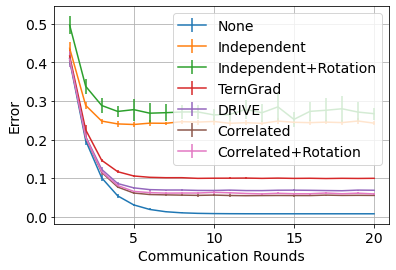

In [63]:
STOP = 20
for quantizer_name, metrics in experiment_power_metrics['num_levels=2 seed=47'].items():
  x = jnp.mean(metrics['comm_rounds'], axis=0)[:STOP]
  y = jnp.mean(metrics['round_l2error'], axis=0)[:STOP]
  yerr = jnp.std(metrics['round_l2error'], axis=0)[:STOP]
  plt.errorbar(x, y, yerr, label=quantizer_name)
  print(quantizer_name, x[-1], y[-1], yerr[-1])
plt.legend()
plt.xlabel('Communication Rounds')
plt.ylabel('Error')
plt.grid()

## Federated MNIST

FedAvg on the federated MNIST dataset.

In [64]:
train_fd, test_fd = fedjax.datasets.emnist.load_data(only_digits=True)
# Hyperparameters for client local traing dataset preparation.
client_batch_hparams = fedjax.ShuffleRepeatBatchHParams(batch_size=20)
# Just read this once for all experiments.
full_test_eval_batches = list(
    fedjax.padded_batch_federated_data(
        test_fd, fedjax.PaddedBatchHParams(batch_size=256)))

100%, elapsed: 1s
100%, elapsed: 0s


In [65]:
model = fedjax.models.emnist.create_logistic_model(only_digits=True)
grad_fn = jax.jit(fedjax.model_grad(model))
# Create federated averaging algorithm.
client_optimizer = fedjax.optimizers.sgd(learning_rate=0.5)
server_optimizer = fedjax.optimizers.sgd(learning_rate=1.0)
# For the sake of saving on redundant compile times, I do this outside of this
# function for the colab only.
with fedjax.for_each_client_backend('pmap'):
  train_for_each_client = fedjax.algorithms.fed_avg.create_train_for_each_client(
      grad_fn, client_optimizer)

ClientId = bytes
Grads = fedjax.Params


@fedjax.dataclass
class ServerState:
  """State of server passed between rounds.

  Attributes:
    params: A pytree representing the server model parameters.
    opt_state: A pytree representing the server optimizer state.
    aggregator_state: Stores the state of the aggregator if non-default
      aggregation is needed.
    aggregated_delta: Aggregated delta stored purely for diagnostics to check
      error of quantization on dist mean estimation.
  """
  params: fedjax.Params
  opt_state: fedjax.OptState
  aggregator_state: Any
  aggregated_delta: fedjax.Params


def federated_averaging(
    grad_fn: Callable[[fedjax.Params, fedjax.BatchExample, fedjax.PRNGKey],
                      Grads],
    client_optimizer: fedjax.Optimizer,
    server_optimizer: fedjax.Optimizer,
    client_batch_hparams: fedjax.ShuffleRepeatBatchHParams,
    aggregator: fedjax.aggregators.Aggregator,
) -> fedjax.FederatedAlgorithm:
  r"""Builds federated averaging.

  Args:
    grad_fn: A function from (params, batch_example, rng) to gradients. This can
      be created with `fedjax.model_grad`. For FedProx the input is (params,
      server_params, batch_example, rng).
    client_optimizer: Optimizer for local client training.
    server_optimizer: Optimizer for server update.
    client_batch_hparams: Hyperparameters for batching client dataset for train.
    aggregator: Aggregator that applies any special techniques to process the
      client updates, for example quantization, before weighting and averaging.
      If none, will use default fedjax.aggregators.mean_aggregator().

  Returns:
    FederatedAlgorithm
  """
  train_for_each_client = fedjax.algorithms.fed_avg.create_train_for_each_client(
      grad_fn, client_optimizer)

  def init(params: fedjax.Params) -> ServerState:
    """Initializes federated averaging server state.

    Args:
      params: Initial model parameters. This could be randomly initialized with
        `fedjax.Model.init` or pre-trained for warm starting.

    Returns:
      Initial server state.
    """
    opt_state = server_optimizer.init(params)
    aggregator_state = aggregator.init()
    aggregated_delta = fedjax.tree_util.tree_zeros_like(params)
    return ServerState(params, opt_state, aggregator_state, aggregated_delta)

  def apply(
      server_state: ServerState,
      clients: Sequence[Tuple[ClientId, fedjax.ClientDataset, fedjax.PRNGKey]]
  ) -> Tuple[ServerState, Mapping[ClientId, Any]]:
    """Runs one round of federated averaging training.

    Args:
      server_state: Input server state containing model parameters and optimizer
        state.
      clients: Clients to train across. Each client has a client id, client
        dataset, and initial rng for training.

    Returns:
      Updated server state and optional per-client diagnostics.
    """
    client_num_examples = {cid: len(cds) for cid, cds, _ in clients}
    # [(client_id, batches, client_input), ...].
    batch_clients = [(cid, cds.shuffle_repeat_batch(client_batch_hparams), crng)
                     for cid, cds, crng in clients]
    client_diagnostics = {}
    shared_input = server_state.params

    # (client ID, params, weights) generator to avoid reading all to memory.
    def generate_client_params_and_weights():
      for client_id, delta_params in train_for_each_client(
          shared_input, batch_clients):
        num_examples = client_num_examples[client_id]
        # Record diagnostics that aren't necessary for training.
        client_diagnostics[client_id] = {}
        client_diagnostics[client_id]['delta_l2_norm'] = (
            fedjax.tree_util.tree_l2_norm(delta_params))
        client_diagnostics[client_id]['delta_minv'] = min(
            jnp.min(l) for l in jax.tree_util.tree_leaves(delta_params))
        client_diagnostics[client_id]['delta_maxv'] = max(
            jnp.max(l) for l in jax.tree_util.tree_leaves(delta_params))
        # This is pretty expensive but we do it here for the sake of measuring
        # distributed mean estimation error.
        client_diagnostics[client_id]['delta_params'] = delta_params
        client_diagnostics[client_id]['weight'] = num_examples
        yield (client_id, delta_params, num_examples)

    client_params_and_weights = generate_client_params_and_weights()
    server_state = server_update(server_state, client_params_and_weights)
    return server_state, client_diagnostics

  def server_update(server_state, client_params_and_weights):
    weighted_averaged_delta, new_aggregator_state = aggregator.apply(
        client_params_and_weights, server_state.aggregator_state)
    opt_state, params = server_optimizer.apply(weighted_averaged_delta,
                                               server_state.opt_state,
                                               server_state.params)
    return ServerState(params, opt_state, new_aggregator_state,
                       weighted_averaged_delta)

  return fedjax.FederatedAlgorithm(init, apply)

In [66]:
@jax.jit
def mean_tree_distance(tree_a, tree_b):
  # PyTree of euclidean distances between leaves of tree_a and tree_b. 
  tree_distance = jax.tree_util.tree_multimap(lambda a, b: jnp.linalg.norm(a - b), tree_a, tree_b)
  distance_leaves = jax.tree_util.tree_leaves(tree_distance)
  # Average euclidean distance across all leaves.
  return sum(distance_leaves) / len(distance_leaves)

In [67]:
def run_fedavg(train_fd,
               test_fd,
               model,
               algorithm,
               rng,
               sample_clients_seed=0,
               num_clients=10,
               num_rounds=2000,
               init_thresholds=None,
               verbose=True):
  # Ground truth mean aggregator
  gt_mean_aggregator = fedjax.aggregators.mean_aggregator()
  gt_mean_state = gt_mean_aggregator.init()
  # Initialization.
  rng, model_rng = jax.random.split(rng)
  init_params = model.init(model_rng)
  server_state = algorithm.init(init_params)
  if init_thresholds is not None:
    # Set correlated thresholds according to init if it's set.
    aggregator_state = server_state.aggregator_state.replace(
        thresholds=init_thresholds)
    server_state = server_state.replace(aggregator_state=aggregator_state)
  round_full_test_loss = []
  round_full_test_acc = []
  round_dme_error = []
  round_delta_minv = []
  round_delta_maxv = []
  comm_rounds = []
  # Train and eval loop.
  train_client_sampler = fedjax.client_samplers.UniformGetClientSampler(
      fd=train_fd, num_clients=num_clients, seed=sample_clients_seed)
  start = time.time()
  for t in range(num_rounds):
    # Sample 10 clients per round without replacement for training.
    clients = train_client_sampler.sample()
    # Run one round of training on sampled clients.
    server_state, client_diagnostics = algorithm.apply(server_state, clients)
    if t % 5 == 0:
      # Check error of mean estimation to ground truth mean aggregator.
      gt_mean_delta, gt_mean_state = gt_mean_aggregator.apply(
          [(cid, cd['delta_params'], cd['weight'])
           for cid, cd in client_diagnostics.items()], gt_mean_state)
      # Periodically evaluate the trained server model parameters.
      full_test_metrics = fedjax.evaluate_model(model, server_state.params,
                                                full_test_eval_batches)
      round_full_test_loss.append(full_test_metrics['loss'])
      round_full_test_acc.append(full_test_metrics['accuracy'])
      round_dme_error.append(
          mean_tree_distance(gt_mean_delta, server_state.aggregated_delta))
      round_delta_minv.append(
          min(d['delta_minv'] for d in client_diagnostics.values()))
      round_delta_maxv.append(
          max(d['delta_maxv'] for d in client_diagnostics.values()))
      comm_rounds.append(t + 1)
      if verbose:
        print(f'[{t}] {round_metrics[t]}')
  end = time.time()
  print(f'Average round duration = {(end - start) / num_rounds} sec')
  return {
      'round_full_test_loss': round_full_test_loss,
      'round_full_test_acc': round_full_test_acc,
      'round_dme_error': round_dme_error,
      'round_delta_minv': round_delta_minv,
      'round_delta_maxv': round_delta_maxv,
      'comm_rounds': comm_rounds,
      'server_state': server_state,
  }


def run_fedavg_experiment(seed, num_levels, num_iters):
  # Logic to avoid redundant experiments for diff num_levels.
  rng = jax.random.PRNGKey(seed)
  experiment_metrics = []
  for trial in range(num_iters):
    rng, use_rng = jax.random.split(rng)
    fedavg_metrics = {}
    use_rng, quant_rng = jax.random.split(use_rng)
    num_clients = 10
    quantizers = get_quantizers(
        rng=quant_rng,
        num_levels=num_levels,
        num_clients=num_clients,
        thresholds=jax.tree_util.tree_map(lambda l: jnp.array([-1.0, 1.0]),
                                          model.init(jax.random.PRNGKey(0))),
        update_thresholds=True)
    for quantizer_name, quantizer in quantizers.items():
      algorithm = federated_averaging(grad_fn, client_optimizer,
                                      server_optimizer,
                                      client_batch_hparams, quantizer)
      init_thresholds = None
      if 'correlated' in quantizer_name:
        # Initialize thresholds for correlated with couple of rounds first.
        s = run_fedavg(
            train_fd,
            test_fd,
            model,
            algorithm,
            use_rng,
            sample_clients_seed=0,
            num_clients=num_clients,
            num_rounds=20,
            verbose=False)['server_state']
        init_thresholds = s.aggregator_state.thresholds
      fedavg_metrics[quantizer_name] = run_fedavg(
          train_fd,
          test_fd,
          model,
          algorithm,
          use_rng,
          sample_clients_seed=0,
          num_clients=num_clients,
          num_rounds=1000,
          init_thresholds=init_thresholds,
          verbose=False)
      print(f'Finished {quantizer_name} trial={trial}')
    experiment_metrics.append(fedavg_metrics)
  return experiment_metrics


experiment_fedavg_metrics = run_fedavg_experiment(
    seed=47, num_levels=2, num_iters=5)

Average round duration = 0.058958380222320556 sec
Finished None trial=0
Average round duration = 0.06221242523193359 sec
Finished Independent trial=0
Average round duration = 0.09018512463569642 sec
Finished Independent+Rotation trial=0
Average round duration = 0.061746336221694946 sec
Finished TernGrad trial=0
Average round duration = 0.08736959981918335 sec


Finished DRIVE trial=0
Average round duration = 0.07089205336570739 sec
Finished Correlated trial=0
Average round duration = 0.0930682921409607 sec
Finished Correlated+Rotation trial=0
Average round duration = 0.057889077663421634 sec
Finished None trial=1
Average round duration = 0.061073004961013796 sec
Finished Independent trial=1
Average round duration = 0.08628395962715149 sec
Finished Independent+Rotation trial=1
Average round duration = 0.06130231928825378 sec
Finished TernGrad trial=1
Average round duration = 0.08800958704948425 sec
Finished DRIVE trial=1
Average round duration = 0.06611519384384155 sec
Finished Correlated trial=1
Average round duration = 0.09171519947052002 sec
Finished Correlated+Rotation trial=1
Average round duration = 0.0588238091468811 sec
Finished None trial=2
Average round duration = 0.06182750654220581 sec
Finished Independent trial=2
Average round duration = 0.08907822632789612 sec
Finished Independent+Rotation trial=2
Average round duration = 0.0615

In [68]:
t = {}
for d in experiment_fedavg_metrics:
  for k, v in d.items():
    if k not in t:
      t[k] = {}
    for ki, vi in v.items():
      if ki not in t[k]:
        t[k][ki] = []
      t[k][ki].append(vi)

for d in experiment_fedavg_metrics:
  for k, v in d.items():
    for ki, vi in v.items():
      if ki != 'server_state':
        t[k][ki] = jnp.array(t[k][ki])

experiment_fedavg_metrics = t

None 99600.0 89.29712 0.0161266
Independent 99600.0 87.39959 0.32088867
Independent+Rotation 99600.0 89.10756 0.081427574
TernGrad 99600.0 88.47179 0.015206117
DRIVE 99600.0 89.2932 0.008108033
Correlated 99600.0 88.38264 0.084860906
Correlated+Rotation 99600.0 89.22169 0.04731172


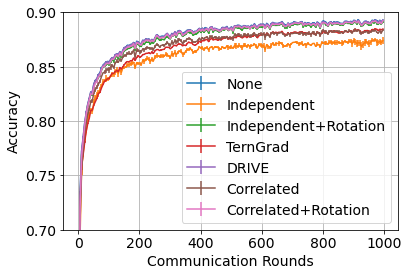

In [69]:
# STOP * 5 is the round number it will stop on.
STOP = 201
for quantizer_name, metrics in experiment_fedavg_metrics.items():
  x = jnp.mean(metrics['comm_rounds'], axis=0)[:STOP]
  y = jnp.mean(metrics['round_full_test_acc'], axis=0)[:STOP]
  yerr = jnp.std(metrics['round_full_test_acc'], axis=0)[:STOP]
  plt.errorbar(x, y, yerr, label=quantizer_name)
  print(quantizer_name, x[-1] * 100, y[-1] * 100, yerr[-1] * 100)
plt.legend()
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy')
plt.ylim((0.7, 0.9))
plt.grid()